# Starbucks Challenge

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import re
import sys
import progressbar
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Cleaning and EDA

## 1. Portfolios

In [2]:
def offer_mapper(df, column_name):
    """
    Maps offer id's to integer values and returns the encoded offers column
    as well as a dictionary of all encodings
    Args:
        df(pd.DataFrame): portfolio dataframe
        column_name(string): column containing id
    Returns: 
        (dict, dict)
    """
    coded_dict = dict()
    counter = 0
    offer_encoded = []
    
    for val in df[column_name]:
        if val not in coded_dict:
            coded_dict[val] = counter
            counter+=1
        
        offer_encoded.append(coded_dict[val])
    return offer_encoded, coded_dict

In [3]:
def clean_portfolio_data(df):
    """
    Cleans the portfolio DataFrame
    Args:
        df(pd.DataFrame): portfolio dataframe
    Returns: 
        (pd.DataFrame, dict)
    """
    #Rename 'id' column to be more specific in case we need to merge
    df.rename(mapper={'id': 'offer_id'}, axis=1, inplace=True)
    
    #Split 'channels' column and create dummies/one-hot-codes
    df = pd.concat([df, df.channels.apply(lambda x: str(x).strip("[]").replace("'", '')).str.get_dummies(', ')], axis=1)
    df.drop(columns=['channels'], inplace=True)
    
    #Encode offer id from 0 to 9
    df.offer_id, offers_dict = offer_mapper(df, 'offer_id')
    
    #Rearrange columns
    columns_list = df.columns.tolist()
    columns_list = columns_list[2:4] + columns_list[:2] + columns_list[4:]
    df = df[columns_list]
    
    #Index
    df = df.set_index('offer_id')
    
    return df, offers_dict

#### Portfolio dataframe before cleaning

In [4]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


#### Portfolio dataframe after cleaning

In [5]:
portfolio, offers_dict = clean_portfolio_data(portfolio)
portfolio.head(10)

,offer_type,difficulty,duration,reward,email,mobile,social,web
offer_id,,,,,,,,
0,bogo,10,7,10,1,1,1,0
1,bogo,10,5,10,1,1,1,1
2,informational,0,4,0,1,1,0,1
3,bogo,5,7,5,1,1,0,1
4,discount,20,10,5,1,0,0,1
5,discount,7,7,3,1,1,1,1
6,discount,10,10,2,1,1,1,1
7,informational,0,3,0,1,1,1,0
8,bogo,5,5,5,1,1,1,1


#### Discount Type promotions are the least offered at 20%

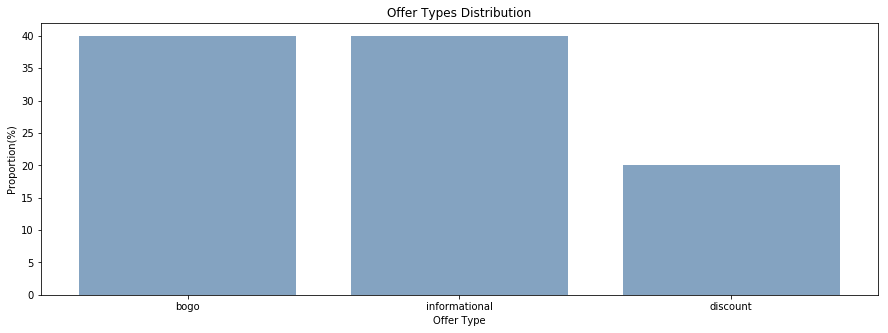

In [6]:
plt.figure(figsize=(15, 5))
plt.bar(x=portfolio.offer_type.unique(),
        height=(portfolio.offer_type.value_counts()/portfolio.shape[0]).values*100,
        color=(0.2, 0.4, 0.6, 0.6))
plt.title('Offer Types Distribution')
plt.xlabel('Offer Type')
plt.ylabel('Proportion(%)');

#### All offers are provided by emails, as long as at least one more channel

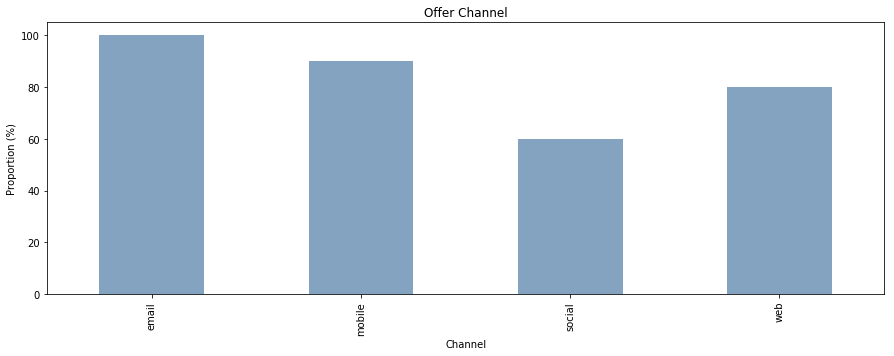

In [7]:
plt.figure(figsize=(15, 5))
(portfolio.iloc[:, 4:].sum()/portfolio.shape[0]*100).plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
plt.title('Offer Channel')
plt.xlabel('Channel')
plt.ylabel('Proportion (%)')
plt.show()

#### It can be seen that there is no direct relation between the difficulty of an offer and the reward

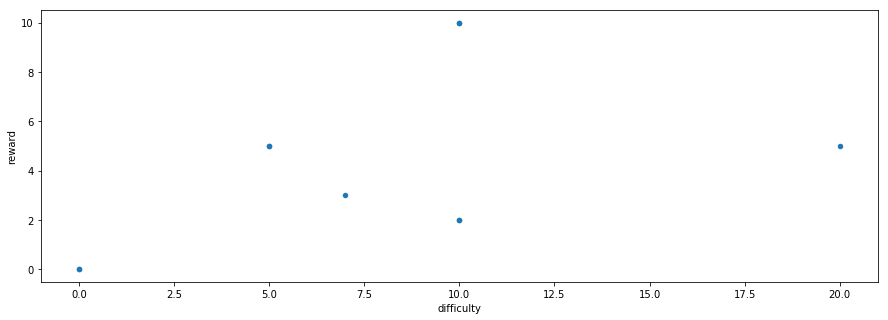

In [8]:
portfolio.plot(x='difficulty', y='reward', kind='scatter', figsize=[15,5]);

#### It can also be seen that there is no direct relation between the duration of an offer and the reward

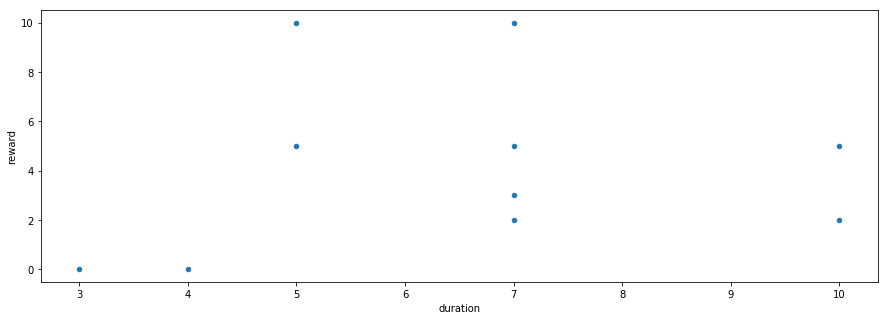

In [9]:
portfolio.plot(x='duration', y='reward', kind='scatter', figsize=[15,5]);

## 2. Profiles

In [10]:
def create_age_ranges(df):
    """
    Creates a dictionary and counts customers who fall
    under a specific age range
    Args:
        df(pd.DataFrame): profile dataframe
    Returns: 
        dict
    """
    ranges = {'10-19': 0,
              '20-29': 0,
              '30-39': 0,
              '40-49': 0,
              '50-59': 0,
              '60-69': 0,
              '70-79': 0,
              '80-89': 0,
              '90-99': 0,
              '100-109': 0}
    for age in df.age.values:
        ranges['{}-{}'.format(age - age%10, age-age%10+9)] += 1
    
    return ranges

In [11]:
def customer_mapper(df, column_name):
    """
    Maps custimer id's to integer values and returns the encoded customers column
    as well as a dictionary of all encodings
    Args:
        df(pd.DataFrame): profile dataframe
        column_name(string): column containing id
    Returns: 
        (dict, dict)
    """
    coded_dict = dict()
    counter = 0
    customer_encoded = []
    
    for val in df[column_name]:
        if val not in coded_dict:
            coded_dict[val] = counter
            counter+=1
        
        customer_encoded.append(coded_dict[val])
    return customer_encoded, coded_dict

In [12]:
def clean_profile_data(df):
    """
    Cleans profile dataframe
    Args:
        df(pd.DataFrame): profile dataframe
    Returns: 
        (pd.DataFrame, dict)
    """
    # Dropping rows with NaN values
    df.dropna(inplace=True)
    
    # Convert became_member_on to date
    df.became_member_on = profile.became_member_on.apply(
        lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))
    df.became_member_on = pd.to_datetime(profile.became_member_on)
    
    #Split 'became_member_on' to 3 more features
    df = pd.concat([profile, profile.became_member_on.astype(str).str.split('-', expand=True).astype(int)], axis=1)
    df.rename(mapper={0: 'year', 1: 'month', 2: 'day'}, axis=1, inplace=True)

    
    # Sort by date
    df = df.sort_values(['became_member_on', 'income'], ascending=False)
    
    # Encode user id to user_id
    df['customer_id'], customer_dict = customer_mapper(df, 'id')
    df.drop(columns=['id'], inplace=True)
    
    # Index
    df =  df.set_index('customer_id')
    
    return df, customer_dict

In [13]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


#### There happens to be NaN rows as well as people with an age of 118, and they happen to occur simaltaneously

In [14]:
# Apparently some users can opt out from sharing gender and income which happens to be the case here
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
profile, customer_dict = clean_profile_data(profile)
profile.head()

,age,became_member_on,gender,income,year,month,day
customer_id,,,,,,,
0,76,2018-07-26,M,92000.0,2018,7,26
1,59,2018-07-26,F,88000.0,2018,7,26
2,63,2018-07-26,M,78000.0,2018,7,26
3,46,2018-07-26,M,74000.0,2018,7,26
4,77,2018-07-26,F,74000.0,2018,7,26


#### Income and Age Analysis

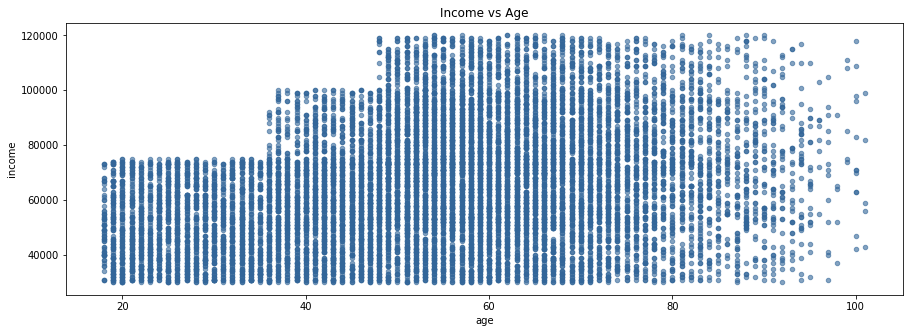

In [16]:
profile.plot(x='age', y='income', title='Income vs Age', kind='scatter', figsize=[15,5], color=(0.2, 0.4, 0.6, 0.6));

In [17]:
print('Average Age: {} \nAverage Income: {}'.format(profile.age.mean(), profile.income.mean()))

Average Age: 54.39352445193929 
Average Income: 65404.9915682968


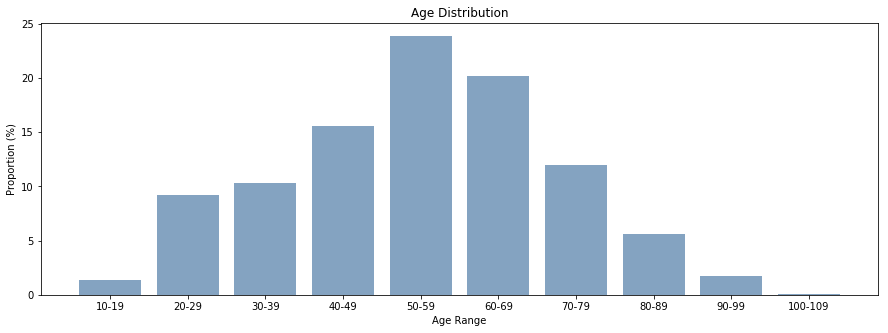

In [18]:
age_data = create_age_ranges(profile)
plt.figure(figsize=(15, 5))
plt.bar(age_data.keys(), height=np.array(list(age_data.values()))/profile.shape[0]*100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Age Distribution')
plt.ylabel('Proportion (%)')
plt.xlabel('Age Range');

#### Gender Analysis


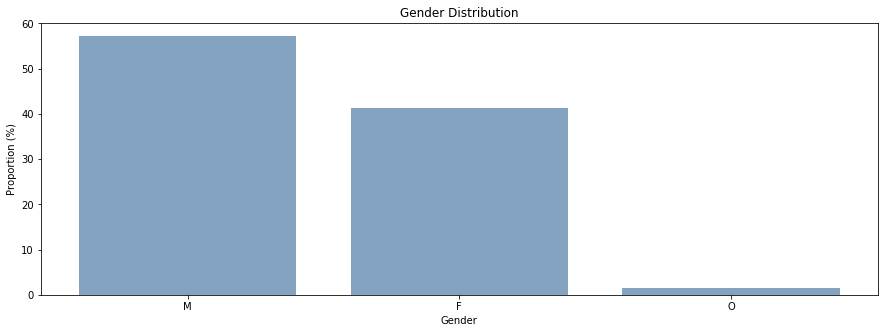

In [19]:
plt.figure(figsize=[15,5])
plt.bar(profile.gender.unique(), profile.gender.value_counts().values/profile.shape[0]*100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Proportion (%)');

#### Membership Analysis

#### Every year the amount of enrolling customers increase, with the biggest increase being from 2017 to 2018

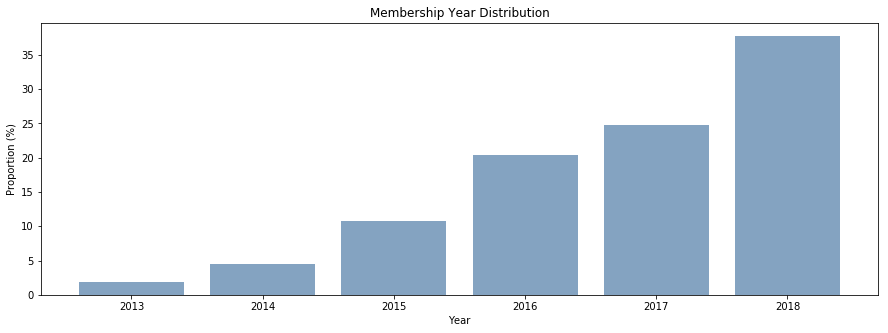

In [20]:
plt.figure(figsize=[15,5])
plt.bar(profile.year.unique(), profile.year.value_counts().values/profile.shape[0]*100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Membership Year Distribution')
plt.xlabel('Year')
plt.ylabel('Proportion (%)');

#### Members tend to enroll in the first 7 months of each year more than the remaining months

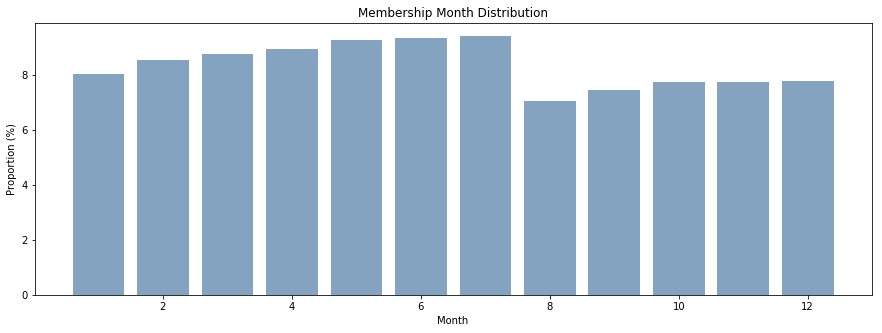

In [21]:
plt.figure(figsize=[15,5])
plt.bar(profile.month.unique(), profile.month.value_counts().values/profile.shape[0]*100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Membership Month Distribution')
plt.xlabel('Month')
plt.ylabel('Proportion (%)');

#### Day of the month does not seem to affect enrolment as much

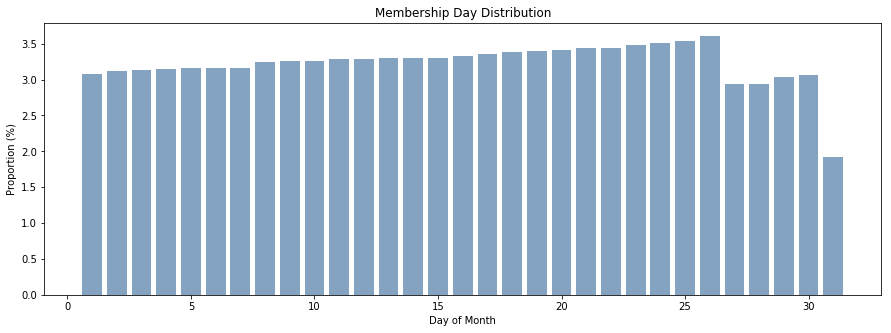

In [22]:
plt.figure(figsize=[15,5])
plt.bar(profile.day.unique(), profile.day.value_counts().values/profile.shape[0]*100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Membership Day Distribution')
plt.xlabel('Day of Month')
plt.ylabel('Proportion (%)');

## 3. Transcripts

In [23]:
def clean_transcript_data(df, customer_dict, offer_dict):
    """
    Cleans transcript dataframe and splits it into
    2 dataframes, one for offers and the other is for
    transactions
    Args:
        df(pd.DataFrame): transactions dataframe
    Returns: 
        (pd.DataFrame, pd.DataFrame)
    """
    # Mapping Customer Dictionary onto person_column
    df.person = df.person.map(customer_dict)
    
    # Dropping rows with NaN values
    df.dropna(inplace=True)
    df.person = df.person.astype(int)
    
    #Reformat the 'value' column for further processing
    p = re.compile(r"\{'offer id': '(.+)\'\}")
    df.value = df.value.astype(str).apply(lambda x: p.sub(r'\1, 0, 0', x))
    p = re.compile(r"\{'offer_id': '(.+)', 'reward': (.+)}")
    df.value =  df.value.apply(lambda x: p.sub(r'\1, \2, 0', x))
    p = re.compile(r"{'amount': (.+)}")
    df.value =  df.value.apply(lambda x: p.sub(r'-1, 0, \1', x))
    
    #Split the 'value' column to 3 columns
    df = pd.concat([df, df.value.str.split(',', expand=True)], axis=1)
    df.drop(columns=['value'], inplace=True)
    df.rename(mapper={'person': 'customer_id', 0:'offer_id', 1: 'reward', 2:'amount'}, axis=1, inplace=True)
    
    #Split results into 2 df's for easier analysis
    offers_transcript = pd.DataFrame(df[df.event != 'transaction'])
    transactions_transcript = pd.DataFrame(df[df.event == 'transaction'])
    
    #Remove redundant columns
    offers_transcript.drop(columns=['amount'], inplace=True)
    offers_transcript.offer_id = offers_transcript.offer_id.map(offer_dict)
    offers_transcript.reward = pd.to_numeric(offers_transcript.reward)
    transactions_transcript.drop(columns=['offer_id', 'reward', 'event'], inplace=True)
    transactions_transcript.amount = pd.to_numeric(transactions_transcript.amount)
    
    return offers_transcript, transactions_transcript

In [24]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


#### It appears that some users do not have a profile, which would make it much harder to work with. Therefore, I'm opting to drop those.

In [25]:
no_profile_entries = transcript.person.map(customer_dict).isnull().sum()
print('Transcript entries with a profile: {}%\nTranscript without a profile: {}%'.format(
    round((transcript.shape[0] - no_profile_entries)/transcript.shape[0]*100, 2),
    round(no_profile_entries/transcript.shape[0]*100),2))


Transcript entries with a profile: 88.98%
Transcript without a profile: 11.0%


#### Split the original transcript dataframe into 2 for easier data processing and extraction, as well as some usual data cleanup

In [26]:
offers_transcript, transactions_transcript = clean_transcript_data(transcript, customer_dict, offers_dict)

#### Transcript of Offers and Rewards for each customer who has a profile

In [27]:
offers_transcript.head()

,event,customer_id,time,offer_id,reward
0,offer received,8223,0,3,0
2,offer received,1550,0,9,0
5,offer received,2834,0,8,0
7,offer received,4947,0,2,0
8,offer received,6446,0,4,0


In [28]:
offers_transcript.shape

(148805, 5)

#### Transcript of amount spent for each customer who has a profile

In [29]:
transactions_transcript.head()

,customer_id,time,amount
12654,10683,0,0.83
12657,12146,0,34.56
12659,3746,0,13.23
12670,5564,0,19.51
12671,4014,0,18.97


In [30]:
transactions_transcript.shape

(123957, 3)

#### Offers Analysis

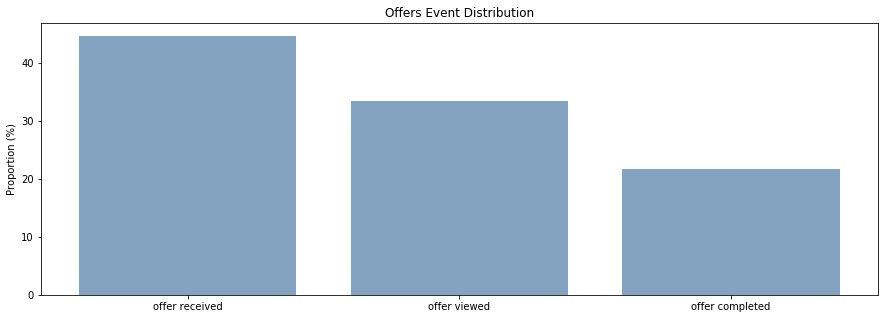

In [31]:
plt.figure(figsize=[15,5])
offer_events = offers_transcript.event.value_counts()
plt.bar(offer_events.index, offer_events.values/offers_transcript.shape[0]*100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Offers Event Distribution')
plt.ylabel('Proportion (%)');

#### It can be seen that offers are sent out without bias, which is an important metric, we have 10 offers and each received offer makes about 10% of the total amount of sent offers

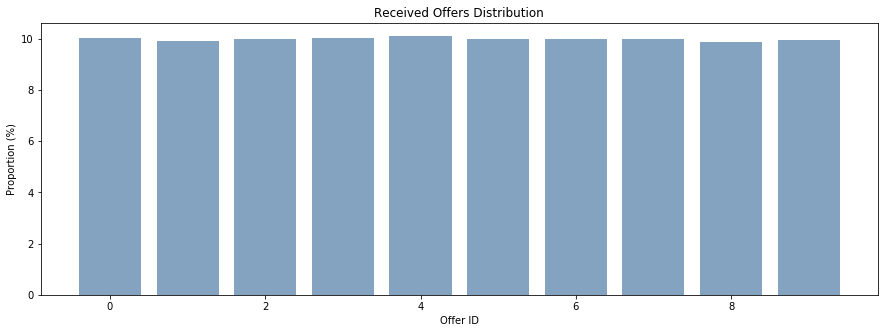

In [32]:
received_offers = offers_transcript[offers_transcript.event == 'offer received'].offer_id.value_counts()
plt.figure(figsize=[15,5])
plt.bar(received_offers.index,
        received_offers.values/offers_transcript[offers_transcript.event == 'offer received'].shape[0]*100,
        color=(0.2, 0.4, 0.6, 0.6))
plt.title('Received Offers Distribution')
plt.xlabel('Offer ID')
plt.ylabel('Proportion (%)');

#### Offer 2, 3,4 and 9 are less likely to be viewed by the users

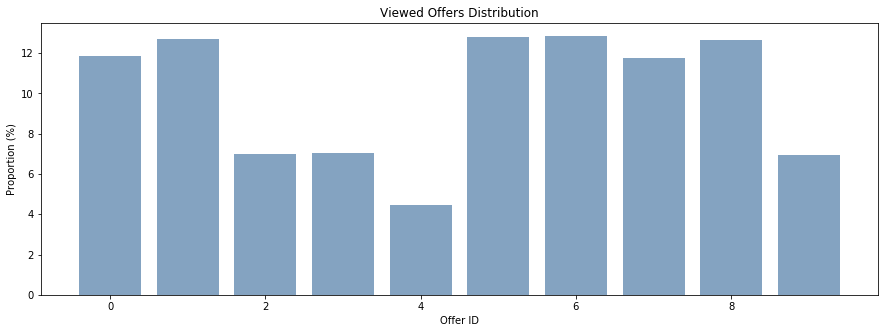

In [33]:
viewed_offers = offers_transcript[offers_transcript.event == 'offer viewed'].offer_id.value_counts()
plt.figure(figsize=[15,5])
plt.bar(viewed_offers.index,
        viewed_offers.values/offers_transcript[offers_transcript.event == 'offer viewed'].shape[0]*100,
        color=(0.2, 0.4, 0.6, 0.6))
plt.title('Viewed Offers Distribution')
plt.xlabel('Offer ID')
plt.ylabel('Proportion (%)');

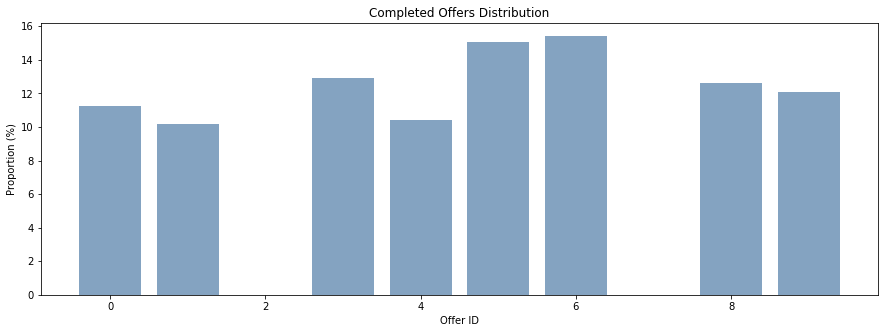

In [34]:
completed_offers = offers_transcript[offers_transcript.event == 'offer completed'].offer_id.value_counts()
plt.figure(figsize=[15,5])
plt.bar(completed_offers.index,
        completed_offers.values/offers_transcript[offers_transcript.event == 'offer completed'].shape[0]*100,
        color=(0.2, 0.4, 0.6, 0.6))
plt.title('Completed Offers Distribution')
plt.xlabel('Offer ID')
plt.ylabel('Proportion (%)');

#### No direct relation can be deduced concering viewed and completed offers. Offers seem to be completed whether or not they are viewed. However, offers with highest completetion rates do have high viewership rates as well

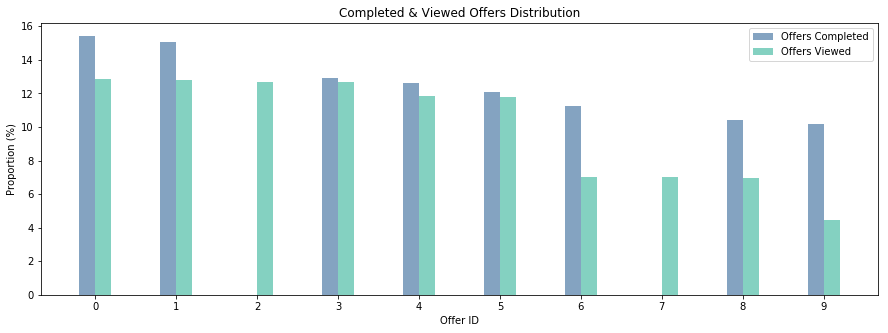

In [35]:

y1 = completed_offers.values/offers_transcript[offers_transcript.event == 'offer completed'].shape[0]*100
y1 = np.insert(y1, 2, 0)
y1 = np.insert(y1, 7, 0)
y2 = viewed_offers.values/offers_transcript[offers_transcript.event == 'offer viewed'].shape[0]*100
x = np.arange(len(y2))

fig, axes = plt.subplots(ncols=1, nrows=1)
width = 0.20
plt.title('Completed & Viewed Offers Distribution')
plt.xlabel('Offer ID')
plt.ylabel('Proportion (%)')
axes.bar(x, y1, width=-1.*width, align='edge', label="Offers Completed", color=(0.2, 0.4, 0.6, 0.6))
axes.bar(x, y2, width=width, align='edge', color=(0.2, 0.7, 0.6, 0.6), label="Offers Viewed")
axes.set_xticks(x)
axes.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
fig.set_figheight(5)
fig.set_figwidth(15)

plt.legend();

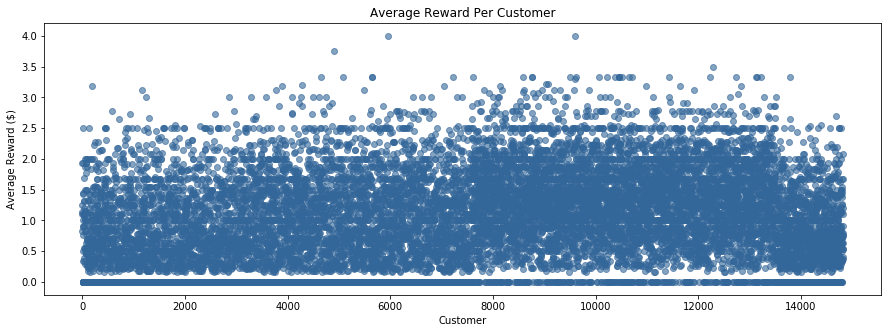

In [36]:
average_reward = offers_transcript.groupby('customer_id').reward.mean()
x = average_reward.index
y = average_reward.values
plt.figure(figsize=[15,5])
plt.scatter(x, y, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Average Reward Per Customer')
plt.xlabel('Customer')
plt.ylabel('Average Reward ($)');

#### Transactions Analysis

##### Most users fall in the region below $30, with lots of outlisers above that mark

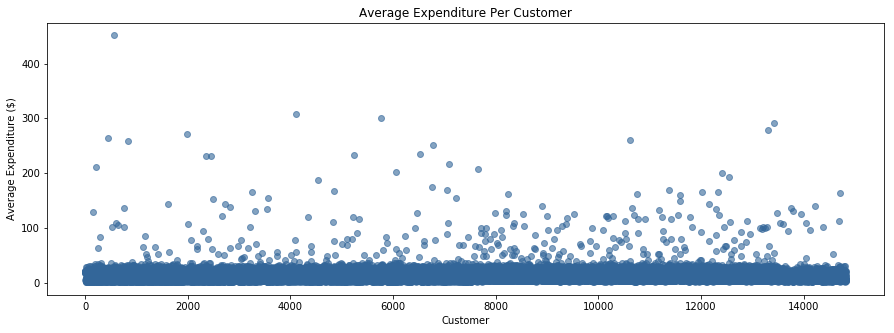

In [37]:
average_expenditure = transactions_transcript.groupby('customer_id').amount.mean()
x = average_expenditure.index
y = average_expenditure.values
plt.figure(figsize=[15,5])
plt.scatter(x, y, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Average Expenditure Per Customer')
plt.xlabel('Customer')
plt.ylabel('Average Expenditure ($)');

##### A slight gap can be seen at around the $5 mark

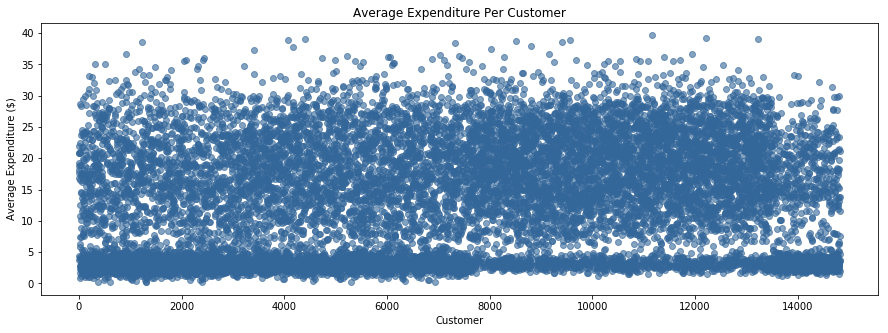

In [38]:
average_expenditure = transactions_transcript.groupby('customer_id').amount.mean()[
    transactions_transcript.groupby('customer_id').amount.mean() < 40]
x = average_expenditure.index
y = average_expenditure.values
plt.figure(figsize=[15,5])
plt.scatter(x, y, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Average Expenditure Per Customer')
plt.xlabel('Customer')
plt.ylabel('Average Expenditure ($)');

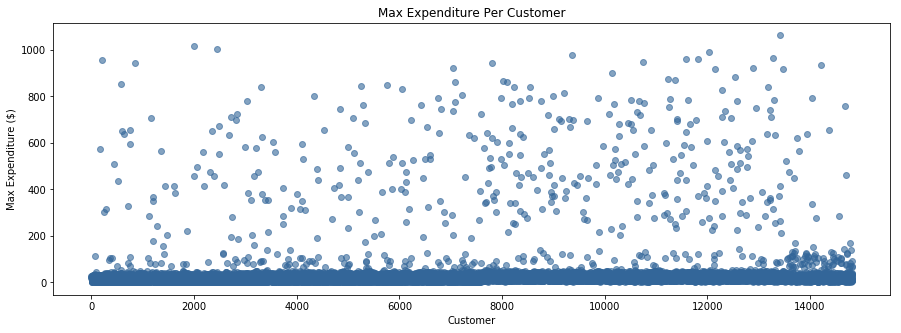

In [39]:
max_expenditure = transactions_transcript.groupby('customer_id').amount.max()
x = max_expenditure.index
y = max_expenditure.values
plt.figure(figsize=[15,5])
plt.scatter(x, y, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Max Expenditure Per Customer')
plt.xlabel('Customer')
plt.ylabel('Max Expenditure ($)');

# 2. Combining the Data

#### Starting to pull all information into 1 dataframe for further analysis and models

In [40]:
profile.head()

,age,became_member_on,gender,income,year,month,day
customer_id,,,,,,,
0,76,2018-07-26,M,92000.0,2018,7,26
1,59,2018-07-26,F,88000.0,2018,7,26
2,63,2018-07-26,M,78000.0,2018,7,26
3,46,2018-07-26,M,74000.0,2018,7,26
4,77,2018-07-26,F,74000.0,2018,7,26


In [41]:
portfolio.head()

,offer_type,difficulty,duration,reward,email,mobile,social,web
offer_id,,,,,,,,
0,bogo,10,7,10,1,1,1,0
1,bogo,10,5,10,1,1,1,1
2,informational,0,4,0,1,1,0,1
3,bogo,5,7,5,1,1,0,1
4,discount,20,10,5,1,0,0,1


In [42]:
transactions_transcript.head()

,customer_id,time,amount
12654,10683,0,0.83
12657,12146,0,34.56
12659,3746,0,13.23
12670,5564,0,19.51
12671,4014,0,18.97


In [43]:
offers_transcript.head()

,event,customer_id,time,offer_id,reward
0,offer received,8223,0,3,0
2,offer received,1550,0,9,0
5,offer received,2834,0,8,0
7,offer received,4947,0,2,0
8,offer received,6446,0,4,0


#### The full_df contains a bunch of new columns that is grabbed from all the dataframes. The profile dataframe is used as the base, and everything is added per customer. Mainly what is being added, is total and average amounts paid per customer and the offers they recevied/completed/viewed

In [44]:
def create_main_dataframe(profile, portfolio, offers_transcript, transactions_transcript):
    """
    Takes in all data frames and creates an all encompasing single dataframe 
    Args:
        profile(pd.DataFrame): profile dataframe
        portfolio(pd.DataFrame): portfolio dataframe
        offers_transcript(pd.DataFrame): offers_transcript dataframe
        transactions_transcript(pd.DataFrame): transactions_transcript dataframe
    Returns: 
        pd.DataFrame
    """
    # Start with the profile dataframe
    combined_df = pd.DataFrame(profile)
    
    # Add some new columns and default the values to NaN
    new_cols = ['total_expenditure', 'avg_expenditure', 'total_reward', 'avg_reward', 'total_offers_received',
                'total_offers_completed', 'total_offers_viewed', 'bogo_offers_received', 'bogo_offers_completed',
                'discount_offers_received', 'discount_offers_completed', 'informational_offers_received']
    for i in range(10):
        new_cols.append('offer_{}_received'.format(i))
    for i in range(10):
        new_cols.append('offer_{}_completed'.format(i))
    for i in range(10):
        new_cols.append('offer_{}_viewed'.format(i))
    for col in new_cols:
        combined_df[col] = 0.0
        
    # Create the progressbar
    cnter = 0
    maxval = (offers_transcript.shape[0] 
              + transactions_transcript.groupby('customer_id').amount.sum().shape[0]*2
              + offers_transcript.groupby('customer_id').reward.sum().shape[0]*2)
             
    bar = progressbar.ProgressBar(
        maxval=maxval, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    # Pulling Offers information
    for _, row in offers_transcript.iterrows():
        cnter+=1 
        bar.update(cnter)        
        if row.event == 'offer received':
            combined_df.at[row.customer_id, 'offer_{}_received'.format(row.offer_id)] += 1
        elif row.event == 'offer completed':
            combined_df.at[row.customer_id, 'offer_{}_completed'.format(row.offer_id)] += 1
        else:
            combined_df.at[row.customer_id, 'offer_{}_viewed'.format(row.offer_id)] += 1           
    
    # Pulling total_expenditure information
    for customer_id, total_amount in transactions_transcript.groupby('customer_id').amount.sum().iteritems():
        cnter+=1 
        combined_df.at[customer_id, 'total_expenditure'] = total_amount
    
    # Pulling avg_expenditure information
    for customer_id, avg_amount in transactions_transcript.groupby('customer_id').amount.mean().iteritems():
        cnter+=1 
        combined_df.at[customer_id, 'avg_expenditure'] = avg_amount
        
    # Pulling total_rewards information
    for customer_id, total_rewards in offers_transcript.groupby('customer_id').reward.sum().iteritems():
        cnter+=1 
        combined_df.at[customer_id, 'total_reward'] = total_rewards
    
    # Pulling avg_rewards information
    for customer_id, avg_rewards in offers_transcript.groupby('customer_id').reward.mean().iteritems():
        cnter+=1 
        combined_df.at[customer_id, 'avg_reward'] = avg_rewards
        
    # Pulling Total Offers
    combined_df.total_offers_received = (combined_df.offer_0_received 
                                        + combined_df.offer_1_received
                                        + combined_df.offer_2_received
                                        + combined_df.offer_3_received
                                        + combined_df.offer_4_received
                                        + combined_df.offer_5_received
                                        + combined_df.offer_6_received
                                        + combined_df.offer_7_received
                                        + combined_df.offer_8_received
                                        + combined_df.offer_9_received)
    
    combined_df.total_offers_completed = (combined_df.offer_0_completed
                                         + combined_df.offer_1_completed
                                         + combined_df.offer_2_completed
                                         + combined_df.offer_3_completed
                                         + combined_df.offer_4_completed
                                         + combined_df.offer_5_completed
                                         + combined_df.offer_6_completed
                                         + combined_df.offer_7_completed
                                         + combined_df.offer_8_completed
                                         + combined_df.offer_9_completed)
    
    combined_df.total_offers_viewed = (combined_df.offer_0_viewed
                                      + combined_df.offer_1_viewed
                                      + combined_df.offer_2_viewed
                                      + combined_df.offer_3_viewed
                                      + combined_df.offer_4_viewed
                                      + combined_df.offer_5_viewed
                                      + combined_df.offer_6_viewed
                                      + combined_df.offer_7_viewed
                                      + combined_df.offer_8_viewed
                                      + combined_df.offer_9_viewed)
    
    # Pulling Total Categeorical Offers
    combined_df.bogo_offers_received  = (combined_df.offer_0_received 
                                        + combined_df.offer_1_received
                                        + combined_df.offer_3_received
                                        + combined_df.offer_8_received)
    
    combined_df.informational_offers_received  = (combined_df.offer_2_received 
                                                 + combined_df.offer_7_received)
    
    combined_df.discount_offers_received  = (combined_df.offer_4_completed 
                                            + combined_df.offer_5_completed
                                            + combined_df.offer_6_completed
                                            + combined_df.offer_9_completed)
    
    combined_df.bogo_offers_completed  = (combined_df.offer_0_completed 
                                         + combined_df.offer_1_completed
                                         + combined_df.offer_3_completed
                                         + combined_df.offer_8_completed)
    
    combined_df.discount_offers_completed  = (combined_df.offer_4_completed 
                                             + combined_df.offer_5_completed
                                             + combined_df.offer_6_completed
                                             + combined_df.offer_9_completed)
    
    combined_df.dropna(axis=0, inplace=True)
    
    bar.finish()
    
    return combined_df

In [45]:
full_df = create_main_dataframe(profile, portfolio, offers_transcript, transactions_transcript)

[========================================================================] 100%


In [46]:
full_df.head()

,age,became_member_on,gender,income,year,month,day,total_expenditure,avg_expenditure,total_reward,...,offer_0_viewed,offer_1_viewed,offer_2_viewed,offer_3_viewed,offer_4_viewed,offer_5_viewed,offer_6_viewed,offer_7_viewed,offer_8_viewed,offer_9_viewed
customer_id,,,,,,,,,,,,,,,,,,,,,
0,76,2018-07-26,M,92000.0,2018,7,26,87.53,21.8825,27.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,59,2018-07-26,F,88000.0,2018,7,26,83.32,20.8300,15.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,63,2018-07-26,M,78000.0,2018,7,26,20.86,20.8600,10.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,46,2018-07-26,M,74000.0,2018,7,26,217.23,18.1025,17.0,...,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,77,2018-07-26,F,74000.0,2018,7,26,67.17,16.7925,10.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0


#### Look at the correlations present for the first 15 columns of the full dataframe

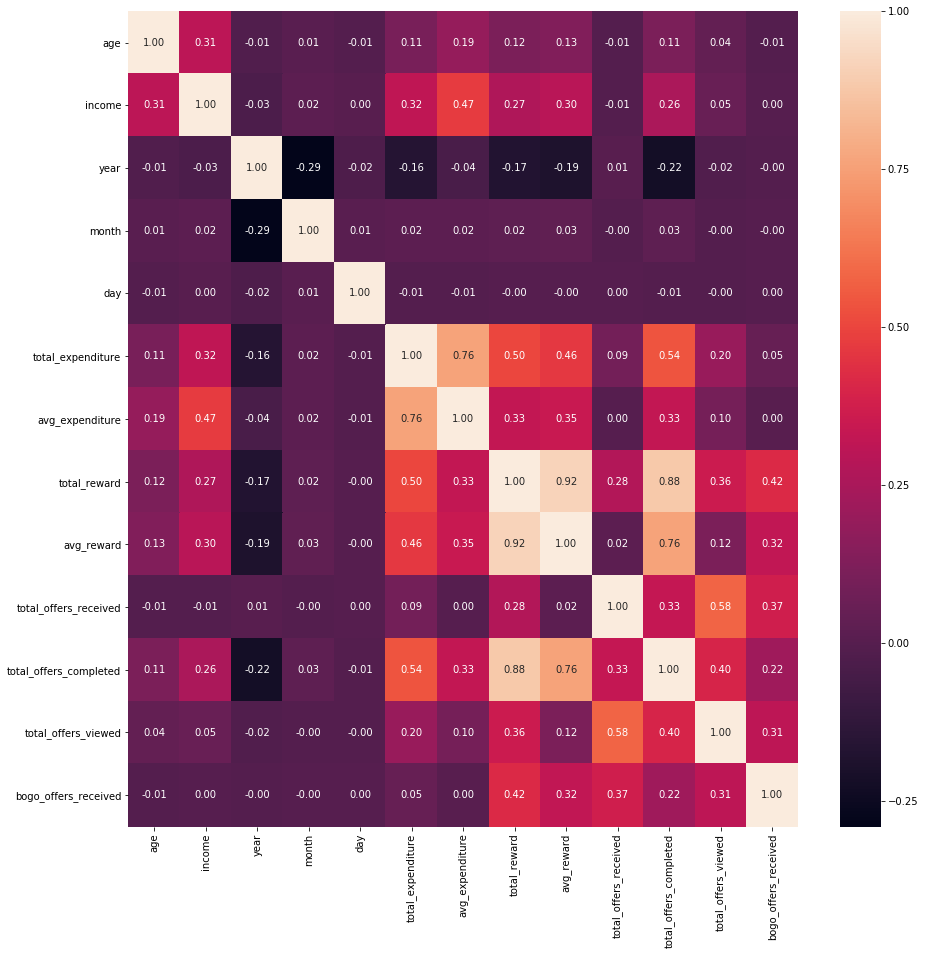

In [47]:
plt.figure(figsize=[15,15])
sns.heatmap(full_df.iloc[:, :15].corr(), annot=True, fmt=".2f")

# 3. Regression Tests

#### Note: Non of the *_ reward nor *_ completed rows are indicative of much, since users will complete offers as they pay more. 

#### However, the interesting findings from the weights coeffcients here are the discount_offers_received, gender_F, offer_2/7_viewed (informationals), and gender_M (negative indicator).

In [48]:
def coef_weights(lm_model, X_train):
    '''
    Returns coefficient weighrs for a linear model
    Args:
        lm_model: the linear model 
        X_train: the training data, so the column names can be used
    Returns:
        pd.DataFrame: a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['Feature'] = X_train.columns
    coefs_df['Coefficient'] = lm_model.coef_
    coefs_df['Abs_Coefficient'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('Abs_Coefficient', ascending=False)
    return coefs_df

In [49]:
np.random.seed(10)

X = pd.concat([full_df.drop(['gender', 'total_expenditure', 'avg_expenditure', 'became_member_on'], axis=1),
               pd.get_dummies(full_df['gender'], prefix='gender', prefix_sep='_')], axis=1)
y = full_df['total_expenditure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

lm_model = Ridge(normalize=True, random_state=10)
lm_model.fit(X_train, y_train)

# Predictions
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Scores
test_score = metrics.r2_score(y_test, y_test_preds)
train_score = metrics.r2_score(y_train, y_train_preds)

print('Test Score: {}\nTrain Score: {}'.format(test_score, train_score))

coef_df = coef_weights(lm_model, X_train)
coef_df[10:20]

Test Score: 0.32339482540928977
Train Score: 0.33246338109820983


,Feature,Coefficient,Abs_Coefficient
12,discount_offers_received,6.874444,6.874444
28,offer_3_completed,5.540987,5.540987
30,offer_5_completed,5.397058,5.397058
45,gender_F,4.312916,4.312916
37,offer_2_viewed,4.256542,4.256542
46,gender_M,-4.192024,4.192024
19,offer_4_received,-3.761637,3.761637
2,year,-3.405815,3.405815
42,offer_7_viewed,3.387954,3.387954
22,offer_7_received,3.325973,3.325973


#### Discount offers **received**, and being a Female, are directly linked to customer expenditure

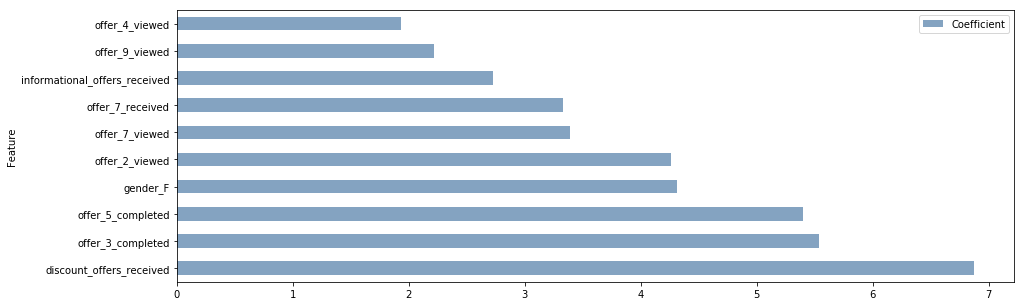

In [50]:
positive_indicators = coef_df.set_index('Feature')
positive_indicators.drop('Abs_Coefficient', axis=1).sort_values(
    'Coefficient', ascending=False)[10:20].plot(kind='barh', figsize=(15,5), color=(0.2, 0.4, 0.6, 0.6));

#### The strongest negative indicator in customer expenditure is being a Male

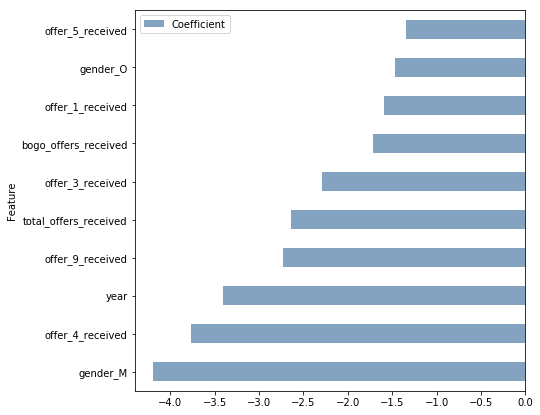

In [51]:
q2_df = coef_df.set_index('Feature')
q2_df.drop('Abs_Coefficient', axis=1).sort_values(
    'Coefficient', ascending=True).head(10).plot(kind='barh', figsize=(7,7), color=(0.2, 0.4, 0.6, 0.6));

# 4. Classfication Models

#### I will use the notion that an effective offer is one that is viewed and completed by customer

In [52]:
offers_info = pd.concat([portfolio.drop(columns=['offer_type']), pd.get_dummies(portfolio.offer_type)], axis=1)
offers_info.head()

,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
offer_id,,,,,,,,,,
0,10,7,10,1,1,1,0,1,0,0
1,10,5,10,1,1,1,1,1,0,0
2,0,4,0,1,1,0,1,0,0,1
3,5,7,5,1,1,0,1,1,0,0
4,20,10,5,1,0,0,1,0,1,0


In [53]:
offers_transcript.head()

,event,customer_id,time,offer_id,reward
0,offer received,8223,0,3,0
2,offer received,1550,0,9,0
5,offer received,2834,0,8,0
7,offer received,4947,0,2,0
8,offer received,6446,0,4,0


In [54]:
def find_effective_offers(df, profile):
    """
    Takes in profile dataframe and offer_transactions dataframe and creates a single
    dataframe that indicates whether an offer is effective or not
    Args:
        df(pd.DataFrame): offers_transcript dataframe
        profile(pd.DataFrame): profile dataframe
    Returns: 
        pd.DataFrame
    """
    df = df.sort_values(['customer_id', 'offer_id'])
    rows_list = []
    for customer_id in sorted(df.customer_id.unique()):
        for offer_id in sorted(df[df.customer_id == customer_id].offer_id.unique()):
            row_dict = {}
            # Fill in customer information
            row_dict['customer_id'] = customer_id
            customer_info = profile.loc[customer_id, ['age', 'gender', 'income', 'year']].values
            row_dict.update({'age': customer_info[0], 'gender': customer_info[1],
                             'income': customer_info[2], 'year': customer_info[3]})
            
            # Fill in offer_information
            row_dict['offer_id'] = offer_id
            offer_info = offers_info.loc[offer_id].values 
            row_dict.update({'difficulty': offer_info[0], 'duration': offer_info[1], 'reward': offer_info[2],
                             'email': offer_info[3], 'mobile': offer_info[4], 'social': offer_info[5],
                             'web': offer_info[6], 'bogo': offer_info[7], 'discount': offer_info[8],
                             'informational': offer_info[9]})
            
            if set(['offer viewed', 'offer completed']).issubset(df[(df.customer_id==customer_id)
                                                                    & (df.offer_id==offer_id)].event.values):
                row_dict['effective_offer'] = 1
            else:
                row_dict['effective_offer'] = 0
                
            rows_list.append(row_dict)

    model_df = pd.DataFrame(rows_list)
    model_df = pd.concat([model_df.drop(columns='gender'), pd.get_dummies(model_df.gender)],axis=1)
    model_df = model_df[['offer_id', 'difficulty', 'duration', 'reward', 'bogo', 'discount', 'informational',
                        'social', 'web', 'mobile', 'email',
                        'customer_id', 'age', 'F', 'M', 'O', 'income', 'year', 
                        'effective_offer']]
    
    return model_df

In [55]:
model_df = find_effective_offers(offers_transcript, profile)
model_df.head()

,offer_id,difficulty,duration,reward,bogo,discount,informational,social,web,mobile,email,customer_id,age,F,M,O,income,year,effective_offer
0,0,10,7,10,1,0,0,1,0,1,1,0,76,0,1,0,92000.0,2018,1
1,4,20,10,5,0,1,0,0,1,0,1,0,76,0,1,0,92000.0,2018,1
2,6,10,10,2,0,1,0,1,1,1,1,0,76,0,1,0,92000.0,2018,1
3,8,5,5,5,1,0,0,1,1,1,1,0,76,0,1,0,92000.0,2018,1
4,0,10,7,10,1,0,0,1,0,1,1,1,59,1,0,0,88000.0,2018,0


## Testing A Naive Predictor as a Base Case

#### We can see the misclassification rate is very large

In [56]:
X = model_df.drop(['effective_offer', 'customer_id', 'offer_id'], axis=1)
y = model_df['effective_offer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

n_pred_preicision = metrics.precision_score(y_test ,np.ones(len(y_test)))
n_pred_recall= metrics.recall_score(y_test,np.ones(len(y_test)))
n_pred_f1score = metrics.f1_score(y_test, np.ones(len(y_test)))
n_pred_misclassfication =  1 - metrics.accuracy_score(y_test, np.ones(len(y_test)))

print("Precision: {}\nRecall: {}\nf1-score: {}\nMisclassfication Rate: {}".format(
    n_pred_preicision,n_pred_recall, n_pred_f1score, n_pred_misclassfication))

Precision: 0.4216387505658669
Recall: 1.0
f1-score: 0.5931728442236658
Misclassfication Rate: 0.578361249434133


## Build and Evaluate a Random Forest Classifier

In [57]:
def build_RFC():
    """
    Builds a pipeline and returns it
    Returns: sklearn.pipeline.Pipeline
    """
    clf = RandomForestClassifier()
    
    parameters  = {'n_estimators': [10, 100, 150, 200, 300],
                   'max_features': ['auto', 'sqrt'],
                   'max_depth': [x for x in range(3, 10)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}

    cv = RandomizedSearchCV(clf,
                            param_distributions = parameters,
                            scoring='f1_weighted',
                            n_iter = 100,
                            cv = 3,
                            verbose=3,
                            random_state=10,
                            n_jobs = 4)

    return cv

In [58]:
def evaluate_model(model, X_test, y_test):
    """
    Uses sklearn's metrics functions to evaluate the model
    https://www.ritchieng.com/machine-learning-evaluate-classification-model/
    Args:
        model(GridSearchCV): a pipeline or ml model
        X_test(pd.DataFrame): test data
        y_test(pd.DataFrame): target values test data
    Returns: None
    """
    # F1 Score
    y_pred = model.predict(X_test)
    print('Best parameters for model are:\n', model.best_params_)
    print(metrics.classification_report(y_test, y_pred))
    
    # Confustion Metrics
    confusion = metrics.confusion_matrix(y_test, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    print('True Positives: {}\nTrue Negatives:{}\nFalsePositives: {}\nFalse Negatives: {}'.format(TP, TN, FP, FN))
    
    # Misclassification
    print('Classification Error: ', 1 - metrics.accuracy_score(y_test, y_pred))
    
    # Sensitivity
    print('Sensitivity: ', metrics.recall_score(y_test, y_pred))

In [59]:
X_rf = model_df.drop(['effective_offer', 'customer_id', 'offer_id'], axis=1)
y_rf = model_df['effective_offer']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=.2)

rf_clf = build_RFC()

rf_clf.fit(X_train_rf, y_train_rf);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   50.5s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  2.0min finished


#### The Classification error is relatively low compared to the naive predictor. and the weighted f1_score is also pretty good

In [60]:
evaluate_model(rf_clf, X_test_rf, y_test_rf)

Best parameters for model are:
 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 9}
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      6307
           1       0.71      0.73      0.72      4738

   micro avg       0.75      0.75      0.75     11045
   macro avg       0.75      0.75      0.75     11045
weighted avg       0.75      0.75      0.75     11045

True Positives: 3462
True Negatives:4859
FalsePositives: 1448
False Negatives: 1276
Classification Error:  0.24662743322770486
Sensitivity:  0.7306880540312368


## Build and Evaluate Logreg Classifier

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
def build_logreg():
    """
    Builds a Logistic Regression Classifier and returns it
    Returns: sklearn.pipeline.Pipeline
    """
    clf = LogisticRegression()
    
    parameters  = {'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.1, 0.01]}

    cv = RandomizedSearchCV(clf,
                            param_distributions = parameters,
                            scoring='f1_weighted',
                            n_iter = 100,
                            cv = 3,
                            verbose=3,
                            random_state=10,
                            n_jobs = 4)

    return cv

In [63]:
X_logreg = model_df.drop(['effective_offer', 'customer_id', 'offer_id'], axis=1)
y_logreg = model_df['effective_offer']

X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X_logreg, y_logreg, test_size=.2)

logreg_clf = build_logreg()

logreg_clf.fit(X_train_logreg, y_train_logreg);

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    4.4s finished


#### Logistic Regression Classifier underperfroms compared to RFC

In [64]:
evaluate_model(logreg_clf, X_test_logreg, y_test_logreg)

Best parameters for model are:
 {'penalty': 'l1', 'C': 0.1}
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      6327
           1       0.67      0.70      0.69      4718

   micro avg       0.73      0.73      0.73     11045
   macro avg       0.72      0.72      0.72     11045
weighted avg       0.73      0.73      0.73     11045

True Positives: 3291
True Negatives:4728
FalsePositives: 1599
False Negatives: 1427
Classification Error:  0.27397012222725214
Sensitivity:  0.6975413310724884


#### That is to be expected since the data is highly non-linear and therefore a linear classifier would tend to underperform compared to a Tree when which does take non-linear decision boundaries into account

## Fine Tuning RFC

In [65]:
def build_RFC_gscv():
    """
    Builds a pipeline and returns it
    Returns: sklearn.pipeline.Pipeline
    """
    clf = RandomForestClassifier()
    
    parameters  = {'n_estimators': [10, 100, 150, 200, 300],
                   'max_features': ['auto', 'sqrt'],
                   'max_depth': [x for x in range(3, 10)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}

    cv = GridSearchCV(clf,
                      param_grid=parameters,
                      scoring='f1_weighted',
                      cv = 3,
                      verbose=3,
                      n_jobs = 4)

    return cv

In [66]:
X_rf_gscv = model_df.drop(['effective_offer', 'customer_id', 'offer_id'], axis=1)
y_rf_gscv = model_df['effective_offer']

X_train_rf_gscv, X_test_rf_gscv, y_train_rf_gscv, y_test_rf_gscv = train_test_split(X_rf_gscv, y_rf_gscv, test_size=.2)

rf_clf_gscv = build_RFC_gscv()

rf_clf_gscv.fit(X_train_rf_gscv, y_train_rf_gscv);

Fitting 3 folds for each of 630 candidates, totalling 1890 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:   34.5s
[Parallel(n_jobs=4)]: Done 288 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 512 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 800 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 1152 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done 1568 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done 1890 out of 1890 | elapsed: 12.3min finished


In [67]:
evaluate_model(rf_clf_gscv, X_test_rf_gscv, y_test_rf_gscv)

Best parameters for model are:
 {'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      6357
           1       0.71      0.75      0.73      4688

   micro avg       0.76      0.76      0.76     11045
   macro avg       0.76      0.76      0.76     11045
weighted avg       0.76      0.76      0.76     11045

True Positives: 3519
True Negatives:4889
FalsePositives: 1468
False Negatives: 1169
Classification Error:  0.23875056586690813
Sensitivity:  0.7506399317406144


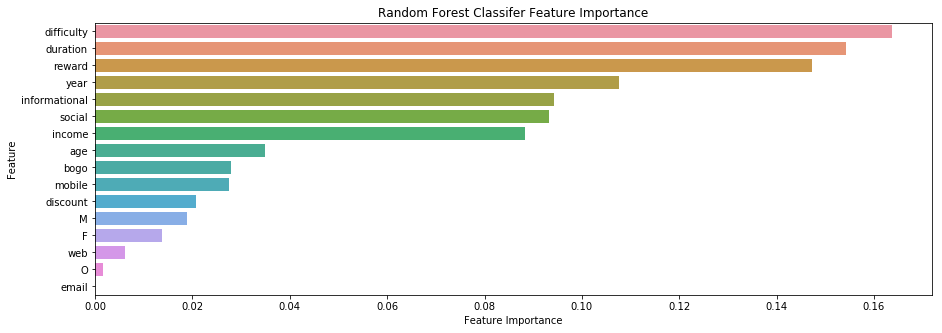

In [71]:
weights = rf_clf_gscv.best_estimator_.feature_importances_

weights_df = pd.DataFrame(list(zip(X_rf_gscv.columns.tolist(), weights)), columns=['feature', 'weight'])
weights_df = weights_df.sort_values('weight',ascending=False)
weights_df = weights_df.reset_index(drop=True)

plt.figure(figsize=(15, 5))
sns.barplot(x='weight', y='feature', data=weights_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Classifer Feature Importance');

# 5. Conclusion

#### The goal from this project was to create a model that is able to predict the effectiveness of a certain offer, provided a certain customer demographic. I also briefly looked at factors affecting customer expenditure.

#### First, I started with some EDA and managed to extract some interesting findings from the data sets, namely:
1. Female Customers tend to spend more than the rest of the customers
2. Discount offers lead to more customer expenditure
3. Customers enrolled in the rewards program are mostly in the 50-59 age group. However, that can be linked to their income being higher than the previous age group
4. Viewed offers tend to be completed more often than offers that were not viewed by customers
5. There is no apparent relation between the reward and difficulty of a certain offer
6. There is no apparent relation between the reward and duration of a certain offer
7. Received offer were distributed evenly. Therefore, the sent amount of an offer was not a biasing factor
8. Genders of Male and Other were negative indicators to expenditure
9. Customers enrolled prior to 2018 are more likely to spend more

#### Afterwards, I moved on to build a simple Naive Classifier to serve as a base case.
It was basically a random classifier, as the f1-score was 60% and the classification error was above 50%.

#### Then I moved on to create a Random Forest Classifier, which served as a non-linear model
The RFC performed quite well compared to our base case and was looking promising

#### To create more base cases, I created a Logistical Regression model, to serve as a linear model
The model did indeed perform worse, which solidifed that a non-linear model would perform better

#### I, then, moved on to performing an exhaustive Grid Search on the RFC
By doing this, I managed to get reach a model with an f1-score of 0.71 and a classifcation error of less than 25%

The most important features for that model were the following:
1. Difficulty
2. Duration
3. Reward

That suggested that an offer tends to be effective due to its own attributes, rather tha being linked to a certain customer demographic. However, age and income also came in 6th and 7th place.

#### The most challenging part
That has to be the data wrangling, really. Cleaning the data and putting it together in a readable and effective way was a challenge and made me go through a couple of hoops to get right. I also found myself forgetting certain features representing it in a manner which is not very usable. However, at the end of the day, I managed to represent the data how I pictured it.

#### Improvements
Since the most important features came from the offers information, that leads me to think that finding more metrics about offer information would lead to a better model. Maybe by creating combinations of these features, or a function of those features, we can end up with a better model.